<a href="https://colab.research.google.com/github/kishore145/AI-ML-Foundations/blob/master/Neural%20Networks/09_NLP_CNN_based_sentiment_classifier_with_roc_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import dependencies and Set hyperparameters

In [0]:
# Import dependencies
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding
from tensorflow.keras.layers import Conv1D, SpatialDropout1D, GlobalMaxPooling1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences

import os

from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt


In [0]:
# Set hyperparameters
# Set o/p directory
output_dir = 'model_output/conv_1'

# training
epochs = 4
batch_size = 128

# vector space embeddings
n_dim = 64
n_unique_words = 5000
max_review_length = 400
pad_type = trunc_type = 'pre'
dropout_embed = 0.2

# conv layer
n_conv = 256 # Number of kernels/filters
k_conv = 3 # Kernel size for identifying triplets of words

# dense layer
n_dense = 256
dropout_dense = 0.2


# Data loading and preprocessing

In [0]:
# Load data
(X_train, y_train), (X_valid, y_valid) = imdb.load_data(num_words=n_unique_words)

In [0]:
# Preprocess Data
X_train = pad_sequences(X_train, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)
X_valid = pad_sequences(X_valid, maxlen=max_review_length, padding=pad_type, truncating=trunc_type, value=0)

# Neural Network Section

In [0]:
# Create a sequential Model
model = Sequential()

# Add first hidden layer - Embed layer
model.add(Embedding(input_dim = n_unique_words, 
                    output_dim = n_dim, 
                    input_length = max_review_length))
model.add(SpatialDropout1D(dropout_embed))

# Add second hidden layer - Conv layer
model.add(Conv1D(filters=n_conv, 
                 kernel_size = k_conv, 
                 activation = 'relu'))
model.add(GlobalMaxPooling1D())

# Add third hiddden layer - Dense layer
model.add(Dense(units = n_dense, 
                activation = 'relu'))
model.add(Dropout(dropout_dense))

# Add o/p layer - sigmoid activation function
model.add(Dense(units = 1, activation = 'sigmoid'))

In [6]:
# Review model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 64)           320000    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 400, 64)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 398, 256)          49408     
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 2

In [0]:
# Compile / Configure model
model.compile(optimizer= 'nadam', loss= 'binary_crossentropy', metrics= ['accuracy'])

In [0]:
# Setting model checkpoint
modelcheckpoint = ModelCheckpoint(filepath=output_dir + '/weights.{epoch:02d}.hdf5')

# Verifying o/p path exists
if not os.path.exists(output_dir):
  os.makedirs(output_dir)

In [9]:
# Model training
model.fit(X_train, y_train, 
          batch_size=batch_size, epochs= epochs, verbose = 1, 
          validation_data = (X_valid, y_valid), 
          callbacks = [modelcheckpoint])

Epoch 1/4
196/196 [==============================] - 5s 25ms/step - loss: 0.4790 - accuracy: 0.7473 - val_loss: 0.3363 - val_accuracy: 0.8536
Epoch 2/4
196/196 [==============================] - 5s 24ms/step - loss: 0.2540 - accuracy: 0.8972 - val_loss: 0.3427 - val_accuracy: 0.8555
Epoch 3/4
196/196 [==============================] - 5s 24ms/step - loss: 0.1854 - accuracy: 0.9293 - val_loss: 0.2743 - val_accuracy: 0.8895
Epoch 4/4
196/196 [==============================] - 5s 24ms/step - loss: 0.1250 - accuracy: 0.9564 - val_loss: 0.2839 - val_accuracy: 0.8904


# Model Evaluation

In [0]:
# Load model with best acccuracy - In my case, it's the latest epoch
# Still loading using load function for showing functionality
model.load_weights(filepath = output_dir + '/weights.04.hdf5')

In [15]:
model.evaluate(X_valid, y_valid)

782/782 [==============================] - 2s 3ms/step - loss: 0.2839 - accuracy: 0.8904


[0.28389886021614075, 0.8903599977493286]

In [0]:
# Predict y_hat
y_hat = model.predict(X_valid)

In [13]:
# Review len of yhat
len(y_hat)

25000

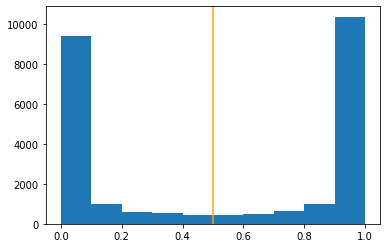

In [14]:
# Plot predictions
plt.hist(y_hat)
_ = plt.axvline(x=0.5, color='orange')

In [16]:
# Find AUC-ROC value
pct_auc = roc_auc_score(y_valid, y_hat)*100.0
print("AUC-ROC Value: {:0.2f}".format(pct_auc))

AUC-ROC Value: 95.90


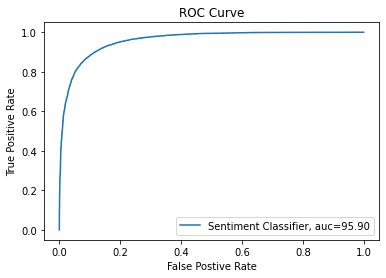

In [17]:
fpr, tpr, auc = roc_curve(y_valid,  y_hat)
plt.plot(fpr,tpr,label="Sentiment Classifier, auc="+"{:0.2f}".format(pct_auc))
plt.legend(loc=4)
plt.title('ROC Curve')
plt.xlabel('False Postive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [0]:
# Concludes sentiment analysis based on CNN architecture